In [1]:
# Load the Pandas library to read experimental data from the Marionette paper [1]
import pandas as pd
# Import pacti PolyhedralContract class to read contracts
from pacti.terms.polyhedra import PolyhedralContract
# Import utility functions for this case study
from utils.synbio_utils import display_sensor_contracts, remove_quantization_errors
# Import pacti PolyhedralContract parent for operations on guarantees
import pacti.terms.polyhedra as gtp
# Import pacti function to write contracts to a file
from pacti import write_contracts_to_file
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# Import Python symbolic computation library: sympy
import sympy
# Import Python numpy
import numpy as np
# Import IO library to write files
import io
# Import random library to generate random numbers
import random

In [2]:
# Read the data from the paper using the CSV file "marionette_data.csv"
df = pd.read_csv("data/marionette_data.csv", delimiter=",", engine="python")

# Add the new "std" column with random values between 0.1 and 0.3
df['std'] = np.random.uniform(0.7, 0.8, len(df))

# Write the updated DataFrame to a new CSV file
df.to_csv('data/marionette_data_with_std.csv', index=False)

In [3]:
df

,Inducer,Plasmid,Regulator,Promoter,ymax (RPU),ymin (RPUx10-3),K (µM),n,Dynamic range,start,ymax Linear,std
0,DAPG,pAJM.847,PhlFAM,PPhlF,2.50,2.5,1.700,2.1,1000,0.0300,2.00,0.727586
1,Cuma,pAJM.657,CymRAM,PCymRC,3.70,4.3,8.900,2.4,870,0.3000,2.00,0.767076
2,OC6,pAJM.474,LuxR,PLuxB,1.30,2.4,0.120,1.8,540,0.0020,0.50,0.750132
3,Van,pAJM.773,VanRAM,PVanCC,3.00,2.4,26.000,2.3,1200,1.0000,1.80,0.728555
4,IPTG,pAJM.336,LacIAM,PTac,3.30,4.8,140.000,1.8,690,2.0000,1.50,0.793668
5,aTc,pAJM.011,TetR,PTet*,2.40,4.9,0.013,3.8,500,0.0018,1.00,0.753502
6,Ara,pAJM.677,AraCAM,PBAD,1.20,2.4,37.000,1.5,500,0.2000,0.70,0.750305
7,Cho,pAJM.683,BetIAM,PBetI,2.60,8.5,4100.000,2.7,310,300.0000,0.90,0.796467
8,Nar,pAJM.661,TtgRAM,PTtg,0.46,3.4,95.000,1.9,140,2.0000,0.20,0.787052
9,DHBA,pAJM.690,PcaUAM,P3B5B,1.60,4.5,370.000,1.8,360,9.0000,1.00,0.753941


In [4]:
def create_sensor_contracts(sensor_input="AHL", output="FP", K=0.0, yleak=0.0,
                            start=0.0, ymax_lin=0.0, std=0.0):
    """
    Creates the contracts for a Marionette sensing subsystem
    params:
        * input (str): The inducer input to the sensor
        * output (str): The output of the genetic construct.
                        Inducer activates the production of this output
        * K (float): The value of the Hill activation parameter K
        * yleak (float): The minimum expression of output even
                         in absence of inducer
        * start (float): The value of inducer at which the induction starts
        * ymax_lin (float): The maximum expression of output by the inducer
                            before saturating (the end of linear regime)
        * std (float): The standard deviation for each value to create contracts
    """    
    yleak1 = yleak + std * yleak
    yleak2 = yleak - std * yleak
    ymax_lin1 = ymax_lin - std*ymax_lin
    ymax_lin2 = ymax_lin + std*ymax_lin
    slope1 = (ymax_lin1 - yleak1) / (K - start)
    slope2 = (ymax_lin2 - yleak2) / (K - start)
    intercept1 = yleak1 - slope1 * start
    intercept2 = yleak2 - slope2 * start
    contract_0 = PolyhedralContract.from_string(
        input_vars=[sensor_input],
        output_vars=[output],
        assumptions=[f"{sensor_input} <= {start}"],
        guarantees=[f"{output} <= {yleak1}",
                    f"-{output} <= {-1 * yleak2}"]
    )                
    contract_lin = PolyhedralContract.from_string(
        input_vars=[sensor_input],
        output_vars=[output],
        assumptions=[
            f"{sensor_input} <= {K}",
            f"-{sensor_input} <= {-1 * start}"
        ],
        guarantees=[
            f"-{output} + {slope1}{sensor_input} <= {-1*intercept1}",
            f"{output} - {slope2}{sensor_input} <= {1 * intercept2}"
        ]
    )
    contract_max = PolyhedralContract.from_string(
        input_vars=[sensor_input],
        output_vars=[output],
        assumptions=[
            f"-{sensor_input} <= {-1 * K}"
        ],
        guarantees=[
            f"-{output} <= {-1 * ymax_lin1}",
            f"{output} <= {ymax_lin2}"
        ]
    )
    return contract_0, contract_lin, contract_max

In [5]:
# Create all sensor contracts:
sensor_names = [str(i) for i in df["Inducer"]]
sensor_library = {}
sensor_library_params = {}
for sensor in sensor_names:
    sensor_params = {}
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]
    yleak_s = yleak_s * 1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    std = df.loc[df["Inducer"] == sensor]["std"].values[0]
    sensor_params = {"leak": yleak_s, "start": s_start,
                     "K": s_K, "ymax": ymax_s, "std":std}
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(
        sensor_input=sensor, output="xRFP", start=s_start, K=s_K,
        ymax_lin=ymax_s, yleak=yleak_s, std=std
    )
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]
    sensor_library_params[sensor] = sensor_params

In [6]:
sensor_library["aTc"]

[<Var InVars: [aTc]
 OutVars:[xRFP]
 A: [
   aTc <= 0.0018
 ]
 G: [
   xRFP <= 0.008592
   -xRFP <= -0.001208
 ]>,
 <Var InVars: [aTc]
 OutVars:[xRFP]
 A: [
   aTc <= 0.013
   -aTc <= -0.0018
 ]
 G: [
   21.24 aTc - xRFP <= 0.02964
   -156.5 aTc + xRFP <= -0.2804
 ]>,
 <Var InVars: [aTc]
 OutVars:[xRFP]
 A: [
   -aTc <= -0.013
 ]
 G: [
   -xRFP <= -0.2465
   xRFP <= 1.754
 ]>]

In [7]:
from pacti.terms.polyhedra import plot_guarantees

In [8]:
# from utils.plotting_utils import stitch_mpl_plots
# output = "xRFP"
# fig, all_ax = plt.subplots(nrows=3, ncols=5, figsize=(32, 20))
# index = 0
# for sensor in sensor_names:
#     ax = all_ax[index // 5][index % 5]
#     index += 1
# #     if sensor == "Ery":
# #         continue
# #     print(sensor)
#     sensor_lims = [0, 1.5*sensor_library_params[sensor]["K"]]
#     output_lims = [0, 1.5*sensor_library_params[sensor]["ymax"]]
#     off_fig = plot_guarantees(sensor_library[sensor][0], 
#                               x_var=sensor,
#                               y_var=output, 
#                               var_values={}, x_lims=sensor_lims, y_lims=output_lims, show=False)
#     lin_fig = plot_guarantees(sensor_library[sensor][1], 
#                               x_var=sensor,
#                               y_var=output, 
#                               var_values={}, x_lims=sensor_lims, y_lims=output_lims, show=False)
#     sat_fig = plot_guarantees(sensor_library[sensor][2], 
#                               x_var=sensor,
#                               y_var=output, 
#                               var_values={}, x_lims=sensor_lims, y_lims=output_lims, show=False)
#     final_fig, ax = stitch_mpl_plots(plots=[off_fig, lin_fig, sat_fig], show=False, ax=ax)
#     ax.set_xlabel(sensor, fontsize=16)
# #     ax.set_xscale("log")
#     ax.tick_params(axis="both", which="major", labelsize=16)
#     ax.set_ylabel("Output", fontsize=16)
# all_ax[2][4].set_axis_off()
# plt.show()

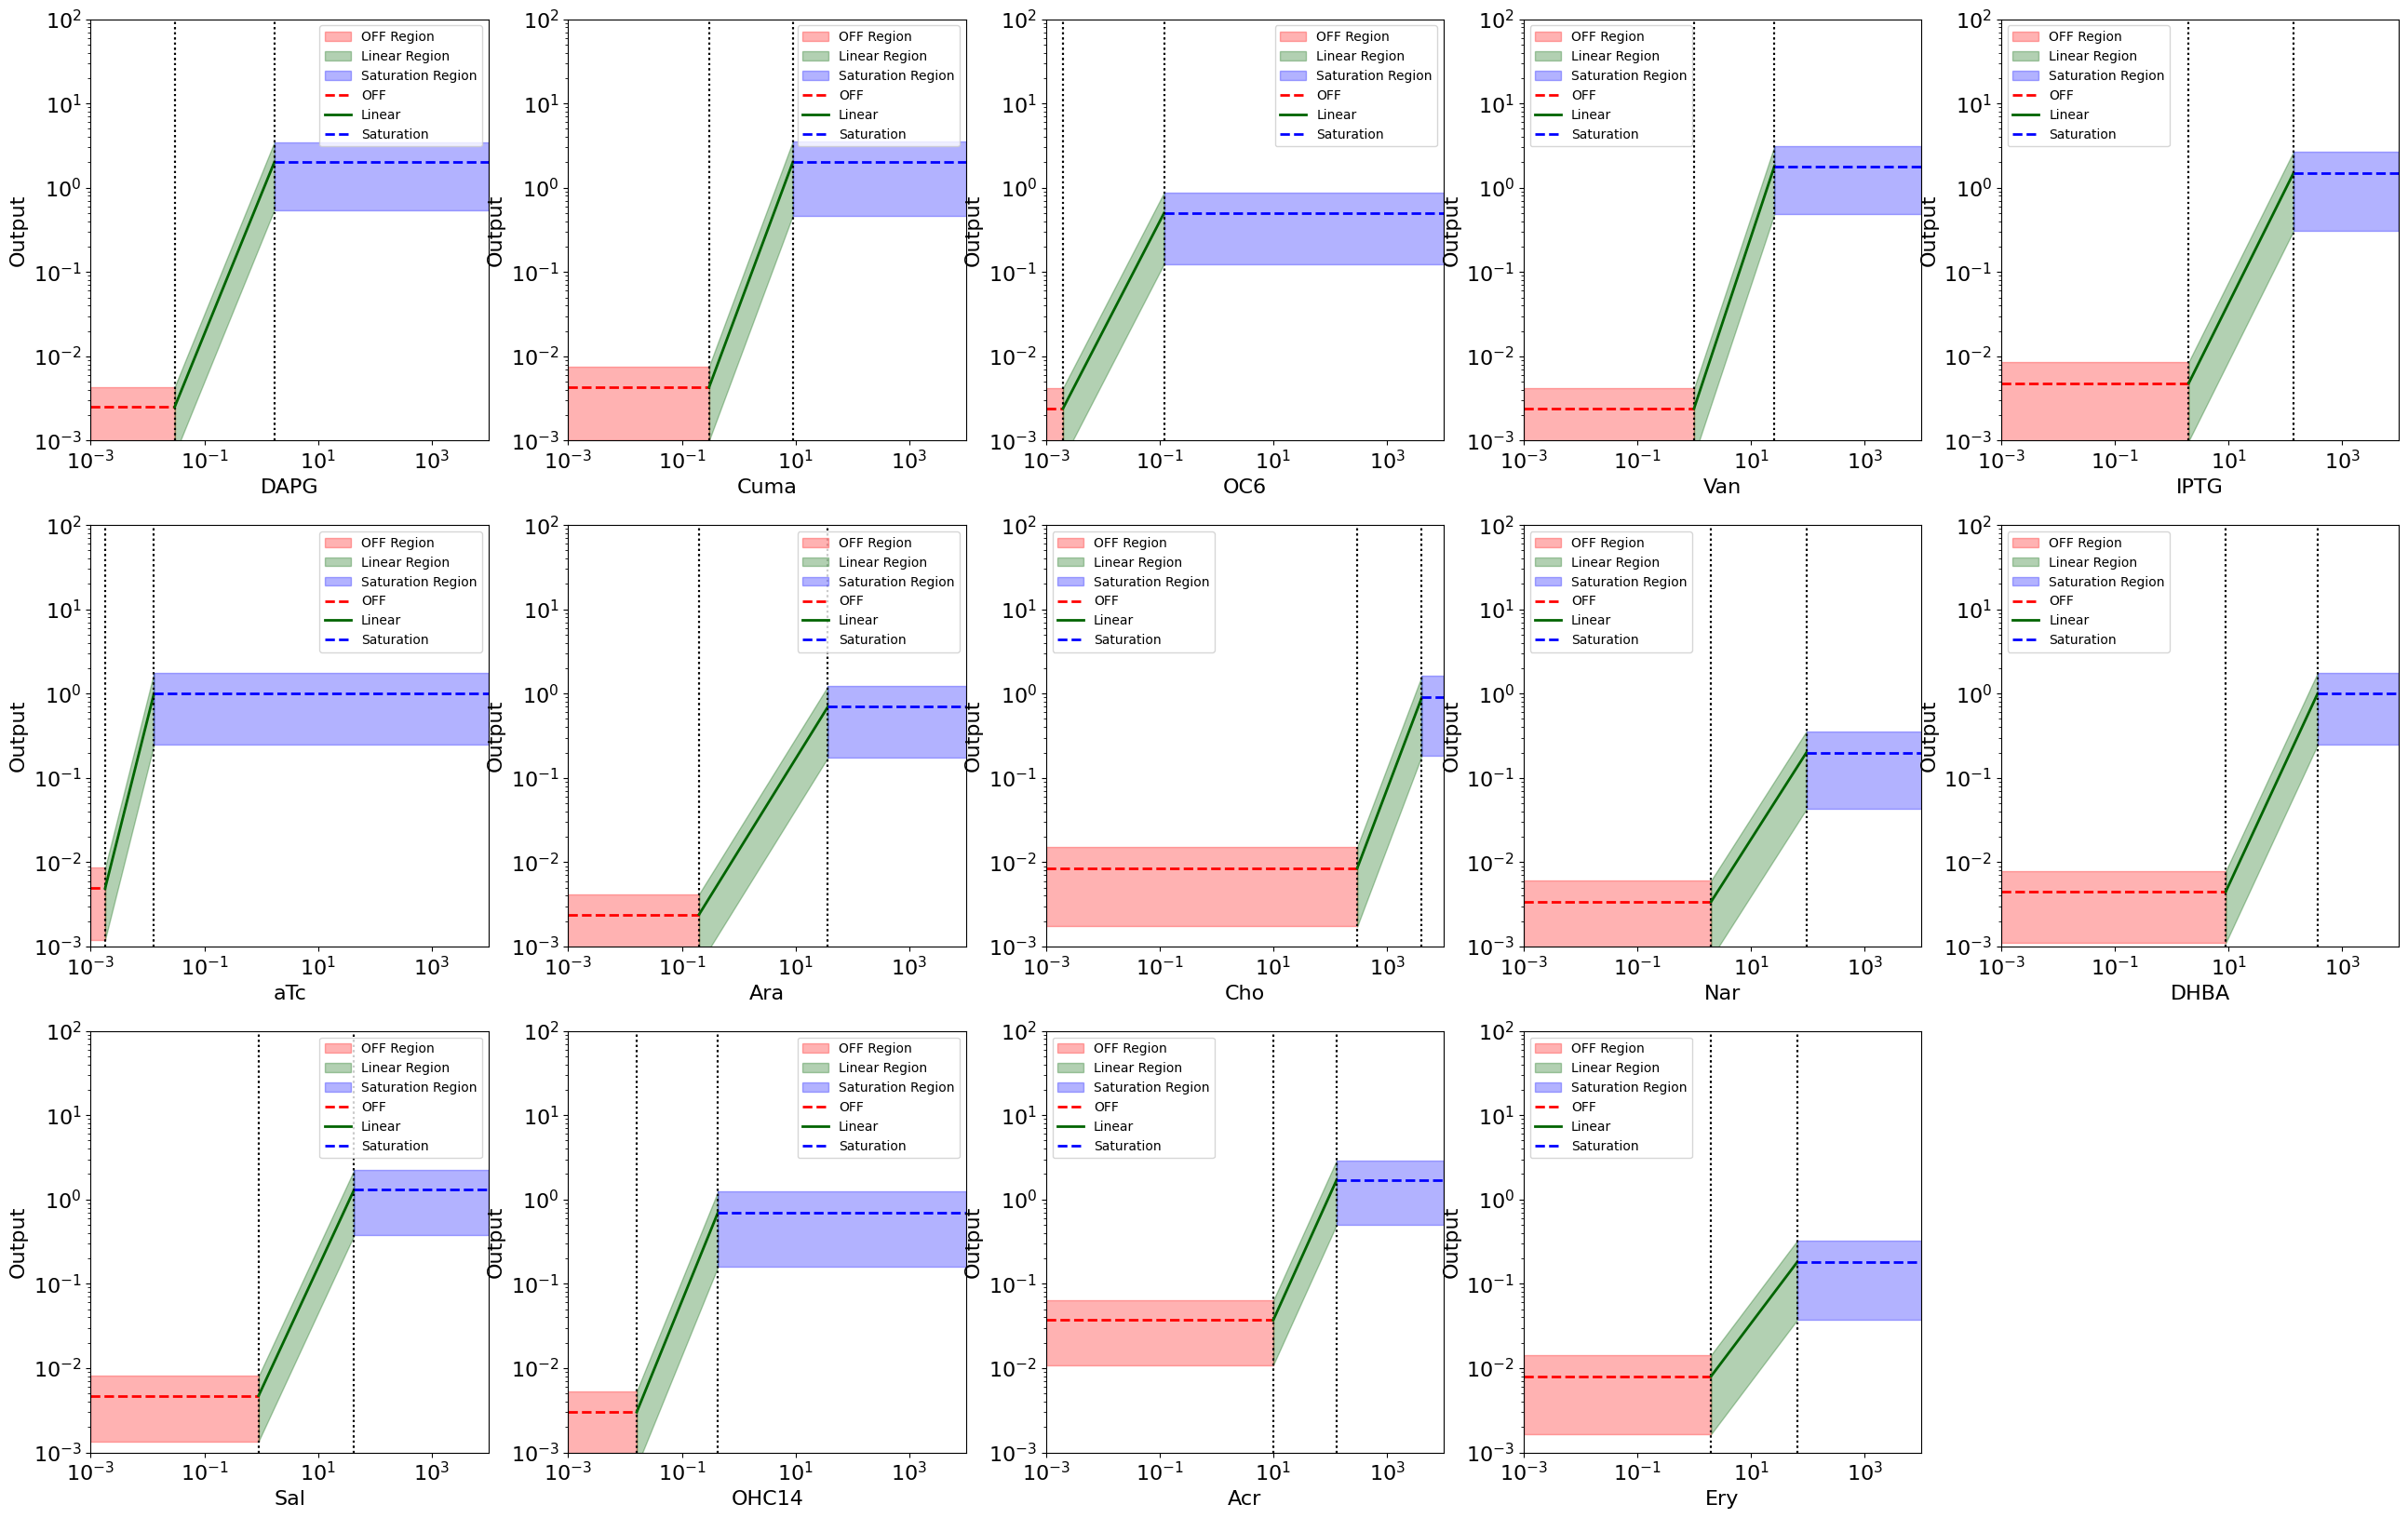

In [9]:
from utils.synbio_utils import display_sensor_contracts_range
output = "xRFP"
fig, all_ax = plt.subplots(nrows=3, ncols=5, figsize=(32, 20))
index = 0
for sensor in sensor_names:
    ax = all_ax[index // 5][index % 5]
    index += 1
    std = df.loc[df["Inducer"] == sensor]["std"].values[0]
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]
    yleak_s = yleak_s * 1e-3
    leak1 = yleak_s + std * yleak_s
    leak2 = yleak_s - std * yleak_s
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    ymax1 = ymax_s + std * ymax_s
    ymax2 = ymax_s - std * ymax_s
    ax = display_sensor_contracts_range(
        sensor_input=sensor,
        output="",
        leak_max=leak1,
        leak_min=leak2,
        start=s_start,
        K=s_K,
        ymax_lin_max=ymax1,
        ymax_lin_min=ymax2,
        xlim_min=10**-3,
        xlim_max=10**4,
        ylim_min=10**-3,
        ylim_max=10**2,
        ax=ax,
        show=False,
        lw=0,
        alpha=0.3
    )
    ax = display_sensor_contracts(
        sensor_input=sensor,
        output="",
        leak=yleak_s,
        start=s_start,
        K=s_K,
        ymax_lin=ymax_s,
        xlim_min=10**-3,
        xlim_max=10**4,
        ylim_min=10**-3,
        ylim_max=10**2,
        ax=ax,
        show=False,
    )
    ax.set_xlabel(sensor, fontsize=16)
#     ax.set_xscale("log")
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.set_ylabel("Output", fontsize=16)
all_ax[2][4].set_axis_off()
plt.show()

## Top-level contract from experimental data 

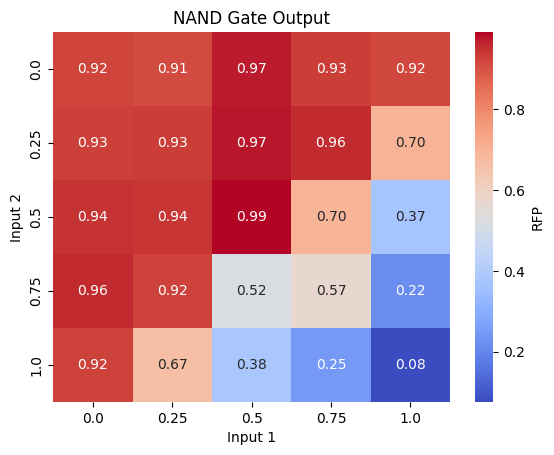

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define input values
aTc = [0, 0.25, 0.5, 0.75, 1]
Sal = [0, 0.25, 0.5, 0.75, 1]

# Generate RFP values that decrease with increasing values of aTc and Sal
RFP = np.zeros((len(aTc), len(Sal)))
for i, atc in enumerate(aTc):
    for j, sal in enumerate(Sal):
        RFP_off = random.uniform(0.01,0.1)
        RFP_on = random.uniform(0.9,1)
        RFP[i, j] = max(RFP_off, min(RFP_on, np.random.normal(2 - atc - sal, 0.1)))

# Convert the data into a Pandas DataFrame
df = pd.DataFrame(RFP, index=aTc, columns=Sal)
# Label the columns of the DataFrame
df.columns.name = 'Sal'
df.index.name = 'aTc'

# Plot the heatmap using Seaborn
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f", cbar_kws={'label': 'RFP'})
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('NAND Gate Output')
plt.show()


In [11]:
def create_top_level_contracts(input1, input2, output, 
                               input1_params, input2_params, output_params):
    """
    Create top-level contracts for the NAND gate using the experimental data
    Arguments:
        * input1 (str): The string name of the first input
        * input2 (str): The string name of the second input
        * output (str): The string name of the output
        * input1_params (dict): A dictionary consisting of keys "max" and "min"
                                for values of input 1
        * input2_params (dict): A dictionary consisting of keys "max" and "min"
                                for values of input 2
        * output_params (dict): A dictionary consisting of keys "max", "high", "min", and "leak"
                                for values of output. Max is the maximum value above which 
                                the circuit will be toxic. High is the acceptable high value 
                                for design performance. Min is the minimum value below which
                                measurements are not possible. Leak is the acceptable leak.
                                So, max > high and leak > min. Circuit performs within the
                                values of leak and high.
    Returns:
        * A tuple of three contracts describing the top-level behavior of the NAND gate.
        The first contract is when the NAND gate is OFF, the second is for the linear response,
        and the third is for the saturation region of the NAND gate.
    """
    in1_max = input1_params["max"]
    in1_min = input1_params["min"]
    in2_max = input2_params["max"]
    in2_min = input2_params["min"]
    out_max = output_params["max"]
    out_high = output_params["high"]
    out_min = output_params["min"]
    out_leak = output_params["leak"]
    # Contract OFF
    contract_off = PolyhedralContract.from_string(
        input_vars = [input1, input2],
        output_vars = [output],
        assumptions = [f'-{input1} <= {-1 * in1_max}', 
                      f'-{input2} <= {-1 * in2_max}'],
        guarantees = [
#                       f'{output} <= {out_leak}',
                      f'{output} + 0.15 * {input1} + 0.15 * {input2} <= {4.8*out_min}',
                      f'-{output} <= {-1*out_min}'
                     ]
    )

    # Contract Linear
    contract_lin = PolyhedralContract.from_string(
        input_vars = [input1, input2],
        output_vars = [output],
        assumptions = [
            f'{input1} <= {in1_max}',
            f'-{input1} <= {-1 * in1_min}',
            f'{input2} <= {in2_max}',
            f'-{input2} <= {-1 * in2_min}',
        ],
        guarantees = [f'{output} + 1.5 * {input1} + 1.5 * {input2} <= {2.05}',
                      f'-{output} - 1.5 * {input1} - 1.5 * {input2} <= {-1.55}'
                     ]
    )

    # Contract Saturation
    contract_sat = PolyhedralContract.from_string(
        input_vars = [input1, input2],
        output_vars = [output],
        assumptions = [f'{input1} <= {in1_min}', 
                      f'{input2} <= {in2_min}'],
        guarantees = [f'-{output} <= {-1 * out_high}',
                      f'{output} + 0.15 * {input1} + 0.15 * {input2} <= {1.42 * out_high}'
                     ]
    )
    return contract_off, contract_lin, contract_sat

In [12]:
# Decide design goals
atc_high_value = np.max(aTc) * 0.8
sal_high_value = np.max(Sal) * 0.8
atc_low_value = 0.1
sal_low_value = 0.1
atc_params = {"min":atc_low_value, "max":atc_high_value}
sal_params = {"min":sal_low_value, "max":sal_high_value}

RFP_low_value = 0.7
RFP_min_value = 0.2
# RFP_high_value = np.max([np.max(df, axis=0), np.max(df, axis=1)]) * 0.8
RFP_high_value = 1.25
# RFP_max_value = np.max([np.max(df, axis=0), np.max(df, axis=1)])
RFP_max_value = 1.75
RFP_params = {"min": RFP_min_value, "leak": RFP_low_value,
              "high": RFP_high_value, "max": RFP_max_value}

top_level_off, top_level_lin, top_level_sat = create_top_level_contracts("aTc", "Sal", "RFP", 
                                                                         atc_params, sal_params, 
                                                                         RFP_params)

In [13]:
top_level_off

<Var InVars: [aTc, Sal]
OutVars:[RFP]
A: [
  -aTc <= -0.8
  -Sal <= -0.8
]
G: [
  RFP + 0.15 Sal + 0.15 aTc <= 0.96
  -RFP <= -0.2
]>

In [14]:
0.25*0.9

0.225

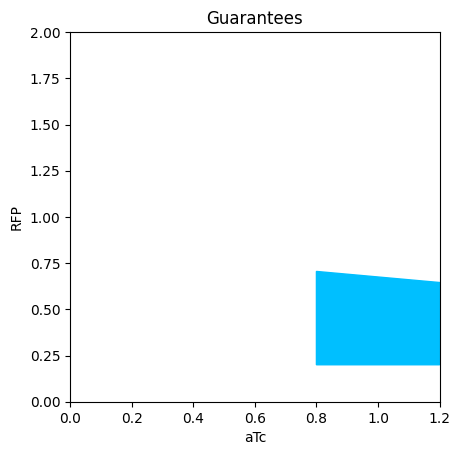

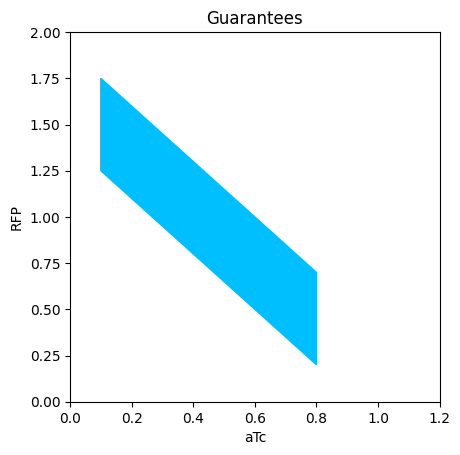

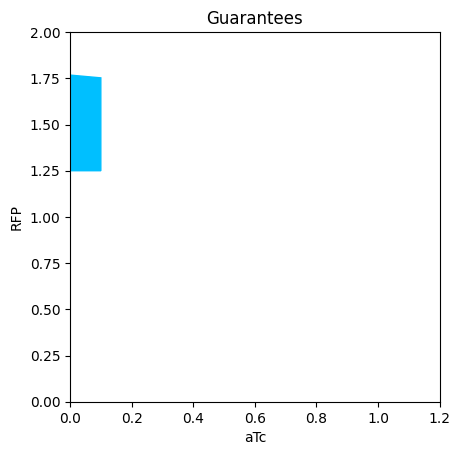

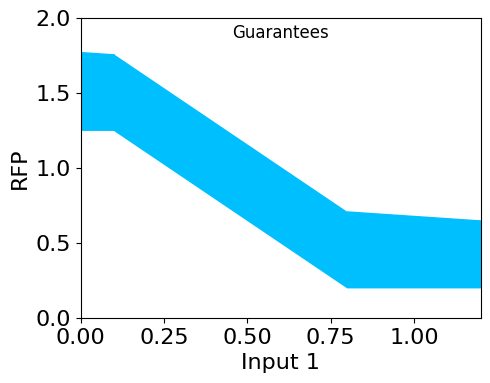

In [15]:
from utils.synbio_utils import stitch_mpl_plots
input1 = "aTc"
input2 = "Sal"
input2_on = 0.9
input2_lin = 0.1
input2_off = 0.05
output = "RFP"
input_lims = [0, 1.5*atc_params["max"]]
# output_lims = [0, 2.5*RFP_params["max"]]
output_lims = [0, 2]
off_fig = plot_guarantees(top_level_off,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_on},
                          x_lims=input_lims, y_lims=output_lims)
lin_fig = plot_guarantees(top_level_lin,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_lin},
                          x_lims=input_lims, y_lims=output_lims)
sat_fig = plot_guarantees(top_level_sat,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_off},
                          x_lims=input_lims, y_lims=output_lims)
final_fig, ax = stitch_mpl_plots(plots=[off_fig, lin_fig, sat_fig], show=False)
ax.set_xlabel("Input 1", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_ylabel(output, fontsize=16)
plt.show()

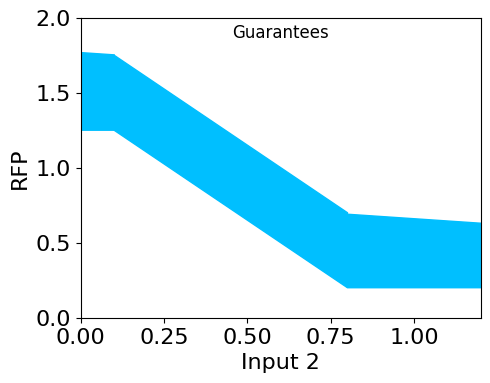

In [16]:
from utils.synbio_utils import stitch_mpl_plots
input1 = "Sal"
input2 = "aTc"
input2_on = 1
input2_lin = 0.1
input2_off = 0.05
output = "RFP"
input_lims = [0, 1.5*atc_params["max"]]
# output_lims = [0, 2.5*RFP_params["max"]]
output_lims = [0, 2]
off_fig = plot_guarantees(top_level_off,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_on},
                          x_lims=input_lims, y_lims=output_lims, show=False)
lin_fig = plot_guarantees(top_level_lin,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_lin},
                          x_lims=input_lims, y_lims=output_lims, show=False)
sat_fig = plot_guarantees(top_level_sat,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_off},
                          x_lims=input_lims, y_lims=output_lims, show=False)
final_fig, ax = stitch_mpl_plots(plots=[off_fig, lin_fig, sat_fig], show=False)
ax.set_xlabel("Input 2", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_ylabel(output, fontsize=16)
plt.show()

## Find missing component: a repressor subsystem

In [17]:
# Decide design goals
atc_high_value = 0.02
atc_low_value = 0.001
sal_high_value = 0.9
sal_low_value = 0.7
atc_params = {"min":atc_low_value, "max":atc_high_value}
sal_params = {"min":sal_low_value, "max":sal_high_value}

RFP_low_value = 0.7
RFP_min_value = 0.2
# RFP_high_value = np.max([np.max(df, axis=0), np.max(df, axis=1)]) * 0.8
RFP_high_value = 1.25
# RFP_max_value = np.max([np.max(df, axis=0), np.max(df, axis=1)])
RFP_max_value = 1.75
RFP_params = {"min": RFP_min_value, "leak": RFP_low_value,
              "high": RFP_high_value, "max": RFP_max_value}

top_level_off, top_level_lin, top_level_sat = create_top_level_contracts("aTc", "Sal", "RFP", 
                                                                         atc_params, sal_params, 
                                                                         RFP_params)

In [18]:
# Create available sensor contracts:

contract_aTc_off, contract_aTc_lin, contract_aTc_sat = create_sensor_contracts(
    sensor_input="aTc", output="dCas9", start=sensor_library_params["aTc"]["start"],
    K=sensor_library_params["aTc"]["K"],
    ymax_lin=sensor_library_params["aTc"]["ymax"], yleak=sensor_library_params["aTc"]["leak"],
    std=sensor_library_params["aTc"]["std"]
)
contract_Sal_off, contract_Sal_lin, contract_Sal_sat = create_sensor_contracts(
    sensor_input="Sal", output="xRFP", start=sensor_library_params["Sal"]["start"],
    K=sensor_library_params["Sal"]["K"],
    ymax_lin=sensor_library_params["Sal"]["ymax"], yleak=sensor_library_params["Sal"]["leak"],
    std=sensor_library_params["Sal"]["std"]
)


In [19]:
sensors_comp = contract_aTc_off.compose(contract_Sal_off)
dCas9_inactive = top_level_sat.quotient(sensors_comp)

In [20]:
top_level_sat

<Var InVars: [aTc, Sal]
OutVars:[RFP]
A: [
  aTc <= 0.001
  Sal <= 0.7
]
G: [
  -RFP <= -1.25
  RFP + 0.15 Sal + 0.15 aTc <= 1.775
]>

In [21]:
dCas9_inactive

<Var InVars: [dCas9, xRFP]
OutVars:[RFP]
A: [
  dCas9 <= 0.008592
  -dCas9 <= -0.001208
  xRFP <= 0.008046
  -xRFP <= -0.001354
]
G: [
  -RFP <= -1.25
  RFP <= 1.64
]>

In [22]:
sensors_comp = contract_aTc_sat.compose(contract_Sal_sat)
dCas9_active = top_level_off.quotient(sensors_comp)

IncompatibleArgsError: Could not eliminate variables 
['aTc', 'Sal']by refining the guarantees 
[
  RFP + 0.15 Sal + 0.15 aTc <= 0.96
  -aTc <= -0.013
  -Sal <= -43
]


In [ ]:
sensors_comp

In [ ]:
sensors_comp = contract_aTc_lin.compose(contract_Sal_lin)
dCas9_active = top_level_lin.quotient(sensors_comp)

In [ ]:
top_level_lin

In [ ]:
1.25/0.7

In [ ]:
# Plot dCas9 repression contracts
from utils.synbio_utils import stitch_mpl_plots
input1 = "dCas9"
input2 = "xRFP"
input2_on = 1
input2_off = 0.003
output = "RFP"
input_lims = [0, 0.35]
output_lims = [0, 2]
off_fig = plot_guarantees(dCas9_inactive,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_off},
                          x_lims=input_lims, y_lims=output_lims, show=False)
on_fig = plot_guarantees(dCas9_active,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_on},
                          x_lims=input_lims, y_lims=output_lims, show=False)
final_fig, ax = stitch_mpl_plots(plots=[off_fig, on_fig], show=False)
ax.set_xlabel("dCas9", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_ylabel(output, fontsize=16)
plt.show()

In [ ]:
# Plot dCas9 repression contracts
from utils.synbio_utils import stitch_mpl_plots
input2 = "dCas9"
input1 = "xRFP"
input2_on = 1
input2_off = 0.003
output = "RFP"
input_lims = [0, 0.35]
output_lims = [0, 2]
off_fig = plot_guarantees(dCas9_inactive,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_off},
                          x_lims=input_lims, y_lims=output_lims, show=False)
on_fig = plot_guarantees(dCas9_active,
                          x_var=input1,
                          y_var=output,
                          var_values={input2:input2_on},
                          x_lims=input_lims, y_lims=output_lims, show=False)
final_fig, ax = stitch_mpl_plots(plots=[off_fig, on_fig], show=False)
ax.set_xlabel("xRFP guide RNA", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_ylabel(output, fontsize=16)
plt.show()

In [ ]:
# For a dCas9 mechanism that works, choose sensor that gives highest fold change
# Our 2nd input is aTc that outputs "dCas9"
# Create the contracts for this sensor
# using our `create_sensor_contracts` function
contract_aTc_off, contract_aTc_lin, contract_aTc_sat = create_sensor_contracts(
    sensor_input="aTc", output="dCas9", start=sensor_library_params["aTc"]["start"],
    K=sensor_library_params["aTc"]["K"],
    ymax_lin=sensor_library_params["aTc"]["ymax"], yleak=sensor_library_params["aTc"]["leak"],
    std=sensor_library_params["aTc"]["std"]
)
in2_params = sensor_library_params["aTc"]
# Now we will go through all other sensors and
# find out which are OK to use given the context
sensor_ok = {}
# We will store all sensor names that are not compatible in a dictionary:
design_error = {}
# We will store the fold-change for all the
# sensors that are OK in this dictionary:
fold_change = {}
# Desired fold change: RFP_on/RFP_off
desired_fold_change = 3
# Go through all sensors in the library except aTc,
# since that has been chosen for the 2nd subsystem
for sensor in sensor_library:
    if sensor == "aTc":
        continue
    in1_params = sensor_library_params[sensor]
    # OFF condition
    # (note that RFP will be ON for this, so we will calculate "rfp_vals_on")
    c_sensor1 = sensor_library[sensor][0]
    c_sensor2 = contract_aTc_off
    # Compose the sensors together
    # (if allowed! => Handle exceptions of the Pacti
    # design error if composition is not allowed)
    try:
        sensor_comp = c_sensor2.compose(c_sensor1)
        top_level_off = sensor_comp.compose(dCas9_inactive)
    except:
        # If Pacti raises a ValueError saying that the composition was
        # "unsatisfiable in context", then that
        # means that this sensor will not work!
#         if "unsatisfiable in context" in str(e):
        design_error[sensor] = False
#         else:
#             raise(e)
    else:
        design_error[sensor] = True
        # If the try block succeeds, this block runs
        # Remove quantization errors that are introduced in solving equations
        top_level_off = remove_quantization_errors(top_level_off)
        # Get the guarantee term and evaluate it
        sym_expr = gtp.PolyhedralTerm.to_symbolic(top_level_off.g.terms[0])
        rfp_vals_on = {}
        updated_sym = sym_expr.subs(sensor, 0.9 * in1_params["start"])
        updated_sym = updated_sym.subs(input2, 0.9 * in2_params["start"])
        subs_val = sympy.solve(updated_sym, "RFP")
        rfp_vals_on[in1_params["start"], in2_params["start"]] = subs_val[0]

    # ON condition
    # (note that RFP will be OFF for this, so we will calculate "rfp_vals_off")
    c_sensor1 = sensor_library[sensor][1]
    c_sensor2 = contract_aTc_lin
    # Compose the sensors together
    # (if allowed! => Handle exceptions of the Pacti
    # design error if composition is not allowed)
    try:
        sensor_comp = c_sensor2.compose(c_sensor1)
        top_level_on = sensor_comp.compose(dCas9_active)
    except:
        # If Pacti raises a ValueError saying that the composition was
        # "unsatisfiable in context", then that means
        # that this sensor will not work!
#         if "unsatisfiable in context" in str(e):
        design_error[sensor] = False
    else:
        design_error[sensor] = True
        # If the try block succeeds, this block runs
        # Remove quantization errors that are introduced in solving equations
        top_level_on = remove_quantization_errors(top_level_on)
        # Get the guarantee term and evaluate it
        sym_expr = gtp.PolyhedralTerm.to_symbolic(top_level_on.g.terms[0])
        rfp_vals_off = {}
        updated_sym = sym_expr.subs(sensor, 0.9 * in1_params["K"])
        updated_sym = updated_sym.subs(input2, 0.9 * in2_params["K"])
        subs_val = sympy.solve(updated_sym, "RFP")
        rfp_vals_off[in1_params["K"], in2_params["K"]] = subs_val[0]
    # Now that we have rfp_vals_on and rfp_vals_off,
    # we can compute the fold change:
    if design_error[sensor]:
        RFP_on = list(rfp_vals_on.values())[0]
        RFP_off = list(rfp_vals_off.values())[0]
        fold_change[sensor] = RFP_on / RFP_off
        if fold_change[sensor] > desired_fold_change:
            sensor_ok[sensor] = True
        else:
            sensor_ok[sensor] = False

In [ ]:
fold_change

In [ ]:
design_error

In [ ]:
top_level_off

Scaling with Pacti

In [ ]:
def create_sensor_contracts(sensor_input="AHL", output="FP", K=0.0, yleak=0.0,
                            start=0.0, ymax_lin=0.0, std=0.0):
    """
    Creates the contracts for a Marionette sensing subsystem
    params:
        * input (str): The inducer input to the sensor
        * output (str): The output of the genetic construct.
                        Inducer activates the production of this output
        * K (float): The value of the Hill activation parameter K
        * yleak (float): The minimum expression of output even
                         in absence of inducer
        * start (float): The value of inducer at which the induction starts
        * ymax_lin (float): The maximum expression of output by the inducer
                            before saturating (the end of linear regime)
        * std (float): The standard deviation for each value to create contracts
    """    
    yleak1 = yleak + std * yleak
    yleak2 = yleak - std * yleak
    ymax_lin1 = ymax_lin - std*ymax_lin
    ymax_lin2 = ymax_lin + std*ymax_lin
    slope1 = (ymax_lin1 - yleak1) / (K - start)
    slope2 = (ymax_lin2 - yleak2) / (K - start)
    intercept1 = yleak1 - slope1 * start
    intercept2 = yleak2 - slope2 * start
    contract_0 = PolyhedralContract.from_string(
        input_vars=[sensor_input],
        output_vars=[output],
        assumptions=[f"{sensor_input} <= {start}"],
        guarantees=[f"{output} <= {yleak1}",
                    f"-{output} <= {-1 * yleak2}"]
    )                
    contract_lin = PolyhedralContract.from_string(
        input_vars=[sensor_input],
        output_vars=[output],
        assumptions=[
            f"{sensor_input} <= {K}",
            f"-{sensor_input} <= {-1 * start}"
        ],
        guarantees=[
            f"-{output} + {slope1}{sensor_input} <= {-1*intercept1}",
            f"{output} - {slope2}{sensor_input} <= {1 * intercept2}"
        ]
    )
    contract_max = PolyhedralContract.from_string(
        input_vars=[sensor_input],
        output_vars=[output],
        assumptions=[
            f"-{sensor_input} <= {-1 * K}"
        ],
        guarantees=[
            f"-{output} <= {-1 * ymax_lin1}",
        ]
    )
    return contract_0, contract_lin, contract_max

In [ ]:
# Create all sensor contracts:
sensor_names = [str(i) for i in df["Inducer"]]
sensor_library = {}
sensor_library_params = {}
for sensor in sensor_names:
    sensor_params = {}
    yleak_s = df.loc[df["Inducer"] == sensor]["ymin (RPUx10-3)"].values[0]
    yleak_s = yleak_s * 1e-3
    s_start = df.loc[df["Inducer"] == sensor]["start"].values[0]
    s_K = df.loc[df["Inducer"] == sensor]["K (µM)"].values[0]
    ymax_s = df.loc[df["Inducer"] == sensor]["ymax Linear"].values[0]
    std = df.loc[df["Inducer"] == sensor]["std"].values[0]
    sensor_params = {"leak": yleak_s, "start": s_start,
                     "K": s_K, "ymax": ymax_s, "std":std}
    s_output = "dCas9"
    contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(
        sensor_input=sensor, output="xRFP", start=s_start, K=s_K,
        ymax_lin=ymax_s, yleak=yleak_s, std=std
    )
    sensor_library[sensor] = [contract_s_0, contract_s_lin, contract_s_max]
    sensor_library_params[sensor] = sensor_params

In [ ]:
outputs = ["x1", "x2", "x3", "x4"]

processor_1 = PolyhedralContract.from_string(
        input_vars = ["x1", "x2"],
        output_vars = ["y1"],
        assumptions = [
            f'-x1 <= {-1 * 0.002}',
            f'-x2 <= {-1 * 0.001}',
        ],
        guarantees = ['y1 <= 2.05',
                     ]
    )
processor_2 = PolyhedralContract.from_string(
        input_vars = ["x3", "x4"],
        output_vars = ["y2"],
        assumptions = [
            f'-x3 <= {-1 * 0.001}',
            f'-x4 <= {-1 * 0.004}',
        ],
        guarantees = ['y2 <= 1.05',
                     ]
    )
processor_3 = PolyhedralContract.from_string(
        input_vars = ["y1", "y2"],
        output_vars = ["y"],
        assumptions = [
            f'-y1 <= {-1 * 0.000004}',
            f'-y2 <= {-1 * 0.000005}',
        ],
        guarantees = ['y <= 2000.05',
                     ]
    )

In [ ]:
import itertools
from pacti.terms.polyhedra.polyhedra import Var
import time
# Get all possible combinations of sensors from the library
number_of_sensors = 4
all_combinations = itertools.combinations(sensor_library.keys(), number_of_sensors)
num_contracts = len(list(all_combinations))
all_combinations = itertools.combinations(sensor_library.keys(), number_of_sensors)
errors_log = []
successful_designs = []
sys_contract = None
t0=time.time()
# Iterate over the combinations
for combo in all_combinations:
    # For this iteration of chosen sensors to use 
    # compute the contracts and store them in a list
    all_sensors_contracts = []
    for sensor, output_i in zip(combo, outputs):
        # For "sensor" input and "output_i" output, we get the contracts:
        contract_s_0, contract_s_lin, contract_s_max = create_sensor_contracts(
            sensor_input=sensor, output=output_i, start=sensor_library_params[sensor]["start"],
            K=sensor_library_params[sensor]["K"], ymax_lin=sensor_library_params[sensor]["ymax"],
            yleak=sensor_library_params[sensor]["leak"], std=sensor_library_params[sensor]["std"],
        )
        if output_i == "x1":
            # Store the contract for the sensor with output "x1"
            sensor1 = contract_s_max
        elif output_i == "x2":
            # Compose the sensor with output "x2" with the stored sensor "sensor1"
            try:
                composed_sensor12 = contract_s_max.compose(sensor1)
            except Exception as e:
                errors_log.append(e)
            # Now, compose 1+2 with processor_1
            try:
                composed_subsys1 = composed_sensor12.compose(processor_1)
            except Exception as e:
                errors_log.append(e)
        if output_i == "x3":
            # Store the contract for the sensor with output "x3"
            sensor3 = contract_s_0
        elif output_i == "x4":
            # Compose the sensor with output "x2" with the stored sensor "sensor1"
            try:
                composed_sensor34 = contract_s_max.compose(sensor3)
            except Exception as e:
                errors_log.append(e)
            # Now, compose 3+4 with processor_2
            try:
                composed_subsys2 = composed_sensor34.compose(processor_2)
            except Exception as e:
                errors_log.append(e)
    try:
        composed_subsys = composed_subsys1.compose(composed_subsys2)
    except Exception as e:
        errors_log.append(e)
    # Finally, compose with processor_3
    try:
        sys_contract = composed_subsys.compose(processor_3)
    except Exception as e:
        errors_log.append(e)
    if sys_contract is not None:
        # Verify whether the final composed system has correct inputs and outputs
        for sensor in combo:
            assert Var(sensor) in sys_contract.inputvars
        for output_i in outputs:
            assert Var(output_i) in sys_contract.outputvars
        # If all works, this is a successful design
        successful_designs.append(sys_contract)
tf = time.time()

In [ ]:
print("Total time taken to compute and operate "
      "on {0} contracts was {1:.2f} seconds leading "
      "to {2} successful system designs.".format(num_contracts, tf-t0,len(successful_designs)))

In [ ]:
errors_log[0]

In [ ]:
contract_s_max